# Basic Momentum Trading in R

**Mometum trading** (or directional trading) is when the financial instrument has an upward/downward trend that can be used in trading.

- A **long-term trend** of the financial asset can provide successful trades in this case

- However, there may be times in which the asset fluctuates randomly and we cannot indentify a clear trend in the instrument

**DOW JONES INDEX:** has experienced an upward trend in the past years, so a momentum trading strategy can be applied in this case.

## 1. Extracting Dow Jones Index

Technical indicators are implemented in the ```quantmod``` package which loads the ```xts``` and ```zoo``` packages.

Extracting DJI data from Yahoo Finance, the data contains the following columns:

- DJI.Open
- DJI.High
- DJI.Low
- DJI.Close

In [3]:
library(quantmod)
getSymbols("^DJI")
dow_jones <- DJI[,"DJI.Close"]
head(dow_jones)

[1] "^DJI"

           DJI.Close
2007-01-03  12474.52
2007-01-04  12480.69
2007-01-05  12398.01
2007-01-08  12423.49
2007-01-09  12416.60
2007-01-10  12442.16

### Extracting the DJI data between two specified dates

In [4]:
dow_jones <- dow_jones[(index(dow_jones) >= "2010-01-01" & index(dow_jones) <= "2017-09-10"),]

### Calculating daily returns using closing prices

Using the ```Delt(index, k = n)``` function one can specify $n$ number of lags which will display in different columns, i.e. ```k=1:3``` for three lags.

In [5]:
return_dow_jones <- Delt(dow_jones, k = 1)

## 2. Backtesting In-Sample Period

Means simulating an investment strategy based in historical data. It is used for calibrating and evaluating an investment strategy, whereby various indicators of risk and return are calculated.

## a. Splitting the data and Calculate Returns

Backtesting the strategy requires splitting the data in two smaller datasets

- **In-sample dataset** (70-80% of the data) is used for parameter estimation and to evaluate the performance

- **Out-sample dataset** (20-30% of the data) the estimated parameters from the *in-sample* data are then used in the *out-sample* data to check their generalisation capacity.

**Validate the Trading Strategy and use it in Live Trading** if the tests using *out-sample* data provide similar results with the *in-sample* test.

**Need to indicate the start and end dates for in-sample and out-sample data:**
 ```
 in_sd -> in-sample data starts
 in_ed -> in-sample data ends
 
 out_sd -> out-sample data starts
 out_ed -> out-sample data ends
 ```
 
 Splitting the dataset into two categoreis helps to control human bias towards parameter estimation.

In [6]:
# In-sample data
in_sd <- "2010-01-01"
in_ed <- "2015-12-31"

# Out-sample data
out_sd <- "2016-01-01"
out_ed <- "2017-09-10"

### Calculate the closing price for the periods:

- Filter the data for the in-sample period

- Calculate the returns of this filtered data

**a. In-Sample:**

In [7]:
# Filter the data for the in-sample period
in_dow_jones <- dow_jones[(index(dow_jones) >= in_sd & index(dow_jones) <= in_ed),]

# Calculate in-sample returns
in_return_dow_jones <- Delt(in_dow_jones, k = 1)

**b. Out-Sample:**

In [8]:
# Filter the data for the out-sample period
out_dow_jones <- dow_jones[(index(dow_jones) >= out_sd & index(dow_jones) <= out_ed),]

# Calculate out-sample returns
out_returns_dow_jones <- Delt(out_dow_jones, k = 1)

## b. Generate Automated Trading Signals

**1. Moving Average Convergnce Divergence (MACD)**

is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

- compares a fast moving average (MA) of a series with a slow MA of the same series. It can be used as a generic oscillator for any univariate series, not only price.

`nFast`   Number of periods for fast moving average.

`nSlow`	  Number of periods for slow moving average.

`nSig`	  Number of periods for signal moving average.

`percent` if TRUE, the percentage difference between the fast and slow moving averages is returned, otherwise the difference between the respective averages is returned.

**2. Bollinger Band Indicators**

is a technical analysis tool defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price

### Step 1. MACD Parameters can be Adjusted Considering the Trading Strategy

In [9]:
# MACD
macd <- MACD(in_dow_jones, nFast = 12, nSlow = 26, nSig = 9,
            maType = "SMA", percent = FALSE)

# Bollinger Bands
bollinger_band <- BBands(in_dow_jones, n = 20, maType="SMA", sd=2)

tail(macd)
tail(bollinger_band)

                 macd     signal
2015-12-23 -156.28995  -73.06066
2015-12-24 -160.01951  -89.60921
2015-12-28 -148.98786 -102.92775
2015-12-29 -136.34931 -113.81799
2015-12-30  -99.66851 -120.82315
2015-12-31  -80.81733 -123.22062

                 dn     mavg       up      pctB
2015-12-23 17153.72 17572.96 17992.20 0.5353618
2015-12-24 17155.42 17559.90 17964.37 0.4904461
2015-12-28 17158.17 17545.64 17933.12 0.4775818
2015-12-29 17158.13 17545.70 17933.27 0.7261331
2015-12-30 17175.67 17531.47 17887.27 0.6017384
2015-12-31 17169.72 17516.24 17862.76 0.3683921

**The trading strategy is based on the following outcomes:**

$\text{Signal}_0 = \text{NULL}$ Initialise signal

$\text{Signal}_i = \text{New Signal} \Rightarrow \begin{cases} \text{DJI > Upper BB & MACD Value > MACD Signal } \rightarrow \text{Buy signal (1)}\\ \text{DJI < lower BB & MACD Value < MACD Signal } \rightarrow \text{Sell signal (-1)} \\ \text{Out of the market } \rightarrow \text{Signal (0)}\end{cases}$

**Considerations on the Process:**

- No transaction costs are included in the analysis

- This strategy can be used for both long and short positions or long only/short only positions

- The exit criterion can be changed

In [10]:
# Initialse the signal
signal <- NULL

# Implement the above outcomes for the new signal
signal <- ifelse(in_dow_jones > bollinger_band[, "up"] & macd[,"macd"] > macd[,"signal"], 1, #cond. 1
          ifelse(in_dow_jones < bollinger_band[, "dn"] & macd[,"macd"] < macd[,"signal"], -1 #cond. 2
                ,0)) #cond. 3

### Step 2. Trade Return is Calculated 

$\text{trade return} = \text{ret}_i * {signal}_{t-i}$

In [11]:
trade_return <- in_return_dow_jones*lag(signal)
trade_return

           Delt.1.arithmetic
2010-01-04                NA
2010-01-05                NA
2010-01-06                NA
2010-01-07                NA
2010-01-08                NA
2010-01-11                NA
2010-01-12                NA
2010-01-13                NA
2010-01-14                NA
2010-01-15                NA
2010-01-19                NA
2010-01-20                NA
2010-01-21                NA
2010-01-22                NA
2010-01-25                NA
2010-01-26                NA
2010-01-27                NA
2010-01-28                NA
2010-01-29                NA
2010-02-01                NA
2010-02-02      0.000000e+00
2010-02-03      0.000000e+00
2010-02-04      0.000000e+00
2010-02-05      0.000000e+00
2010-02-08      0.000000e+00
2010-02-09      0.000000e+00
2010-02-10      0.000000e+00
2010-02-11      0.000000e+00
2010-02-12      0.000000e+00
2010-02-16      0.000000e+00
2010-02-17      0.000000e+00
2010-02-18      0.000000e+00
2010-02-19      0.000000e+00
2010-02-22    

### Step 3. The Strategy Performance can be Checked

using the `PerformanceAnalytics` package.

In [12]:
library(PerformanceAnalytics)

### Step 4. Calculate the Cumulative Return

In [14]:
cumm_return <- Return.cumulative(trade_return)
cumm_return

,Delt.1.arithmetic
Cumulative Return,0.01906121


### Step 5. Calculate the Annualized Return

In [15]:
annual_return <- Return.annualized(trade_return)
annual_return

,Delt.1.arithmetic
Annualized Return,0.003198539


### Step 6. Plot the Cumulative and Daily Returns along with Drawdown at a given point in time

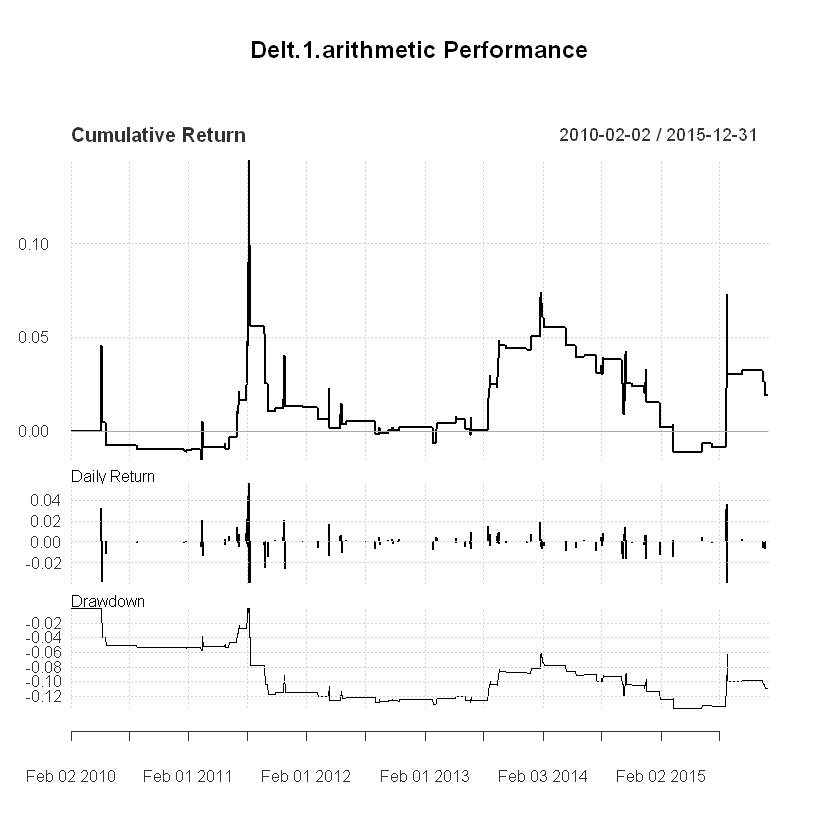

In [16]:
charts.PerformanceSummary(trade_return)

### Step 7. Analyse the details of the trade performance

**Cumulative returns:** are positive at the end of in-sample period, which means that the strategy is profitable. There are however, periods in which the cumulative return becomes negative.

**High Caution:** in the strategy as it has to be tested in the out-sample period!

**Volatility:** there are periods of *high volatility* and periods of *low volatility* according to the daily return chart and cumulative returns. This may indicate *volatility clustering*.

#### Summary and Analytics

- Max Drawdown
- StDev and Annualized StDev
- VaR
- Sharpe Ratio and Annualized Sharpe Ratio

In [25]:
summary(as.ts(trade_return))

# Max Drawdown
print("Max Drawdown:")
maxDrawdown(trade_return)

# St Deviation
StdDev(trade_return)
StdDev.annualized(trade_return)

# VaR
VaR(trade_return, p = 0.95)

# Sharpe Ratio
SharpeRatio(as.ts(trade_return), Rf =0, p = 0.95, FUN = "StdDev")
SharpeRatio.annualized(trade_return, Rf = 0)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-0.03977  0.00000  0.00000  0.00002  0.00000  0.05546       20 

[1] "Max Drawdown:"


[1] 0.1360742

StdDev,0.003920434


,Delt.1.arithmetic
Annualized Standard Deviation,0.06223497


VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.00112204399250961


,Delt.1.arithmetic
VaR,NA


"StdDev Sharpe (Rf=0%, p=95%):",0.005186737


,Delt.1.arithmetic
Annualized Sharpe Ratio (Rf=0%),0.05139457


## 3. Backtesting Out-Sample Period

The strategy here employed provides adequate results for in-sample data, now we have to test for out-sample data.

### Step1. MACD and BB are Calculated for Out-Sample data

In [27]:
macd <- MACD(out_dow_jones, nFast = 7, nSlow = 12, nSig = 15, maType = "SMA", percent = FALSE)

bollinger_band <- BBands(out_dow_jones, n = 20, maType ="SMA", sd = 2)

tail(macd)
tail(bollinger_band)

               macd    signal
2017-08-31 14.77434 -31.88609
2017-09-01 42.95064 -32.10328
2017-09-05 38.43708 -31.21758
2017-09-06 26.48152 -29.29827
2017-09-07 16.35463 -26.42008
2017-09-08 15.20880 -21.61591

                 dn     mavg       up      pctB
2017-08-31 21642.90 21900.88 22158.85 0.5915287
2017-09-01 21649.49 21895.61 22141.73 0.6867942
2017-09-05 21646.35 21877.36 22108.36 0.2315061
2017-09-06 21651.55 21863.47 22075.40 0.3682755
2017-09-07 21653.83 21850.28 22046.73 0.3332992
2017-09-08 21650.19 21847.97 22045.74 0.3731477

### Step 2. Generate Sigals for Out-Sample Data

In [29]:
signal <- NULL
signal <- ifelse(out_dow_jones > bollinger_band[,"up"] & macd[,"macd"] > macd[,"signal"], 1, 
                ifelse(out_dow_jones < bollinger_band[,"dn"] & macd[,"macd"] < macd[,"signal"], -1,
                       0))

In [30]:
trade_return <- out_returns_dow_jones * lag(signal)

### Step 3. Analyse Performance Metrics

,Delt.1.arithmetic
Cumulative Return,-0.00625472


,Delt.1.arithmetic
Annualized Return,-0.003896437


[1] 0.04015567

StdDev,0.001942209


,Delt.1.arithmetic
Annualized Standard Deviation,0.03083161


,Delt.1.arithmetic
VaR,-0.00236668


,Delt.1.arithmetic
"StdDev Sharpe (Rf=0%, p=95%):",-0.007003816


,Delt.1.arithmetic
Annualized Sharpe Ratio (Rf=0%),-0.126378


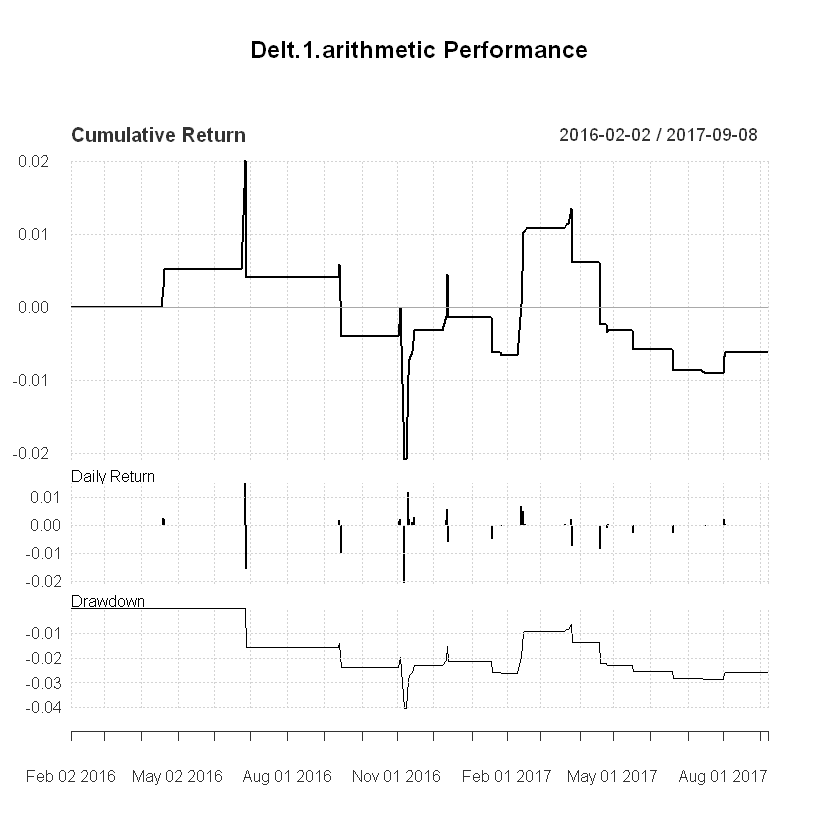

In [31]:
Return.cumulative(trade_return)
Return.annualized(trade_return)
charts.PerformanceSummary(trade_return)
maxDrawdown(trade_return)
StdDev(trade_return)
StdDev.annualized(trade_return)
VaR(trade_return, p = 0.95)
SharpeRatio(trade_return, Rf= 0, p = 0.95, FUN = "StdDev")
SharpeRatio.annualized(trade_return, Rf = 0)

## Conclusion

**Cumulative Returns:** are positive in the first period, ending in negative ground towards the end, indicating that the strategy is not profitable. However, the strategy must be tested on different stocks and periods before reaching a final conclusion regarding profitability.

**Basic Strategy:** This strategy relies only on technical indicators, therefore it can be improved by introducing trading signals generated by ARMA and GARCH forecasts.

**Short Period Predictions:** (t+1) can be generated using ARMA and GARCH

**Long Perdiod Predictions:** using VAR/VEC considering different macro or financial indicators

*an updated version of the strategy can be initially tested in Excel before implementing it in code*.